#LSTM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf

Unpreprocessed file: not executable on Colab because of to little RAM, not executable on own machine since it takes for ever...

Use only one of the following codeblocks to load data and set the image folder of the appropriate dataset.

spam_preprocessed.csv:

In [ ]:
image_folder = 'Figures/lstm_SMS_preprocessed/LSTM_SMS_'
data_path = '../Data/preprocessed/spam_preprocessed.csv'

enron_preprocessed.csv:

In [ ]:
image_folder = 'Figures/lstm_enron_preprocessed/LSTM_ENRON_'
data_path = '../Data/preprocessed/enron_preprocessed.csv'

The following code block should only be used in google colab: 

In [2]:
data_path = "merged_preprocessed.csv"

#MAIN:

In [3]:
print("reading file: ", data_path)
df = pd.read_csv(data_path, encoding = "latin-1")
df.head()

,label,text
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts may...
3,0,u dun say early hor u c already say
4,0,nah think go usf life around though


In [4]:
df.shape

(35193, 2)

#Drop Null values:
Somehow it did not work to drop NULL values in preprocessing... Out of any reason there are some null falues in the data after reading the CSV even though they have not been there before writing the CSV file in the preprocessing skript!

In [5]:
df.isnull().sum()

label     0
text     14
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isnull().sum()

label    0
text     0
dtype: int64

#Balancing Dataset: 

In [7]:
df_spam = df[df['label'] == 1]
df_ham  = df[df['label'] == 0]
print("Ham Dataset Shape:", df_ham.shape)
print("Spam Dataset Shape:", df_spam.shape)


Ham Dataset Shape: (20367, 2)
Spam Dataset Shape: (14812, 2)


In [8]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(14812, 2)

In [9]:
df = pd.concat([df_spam, df_ham_downsampled])

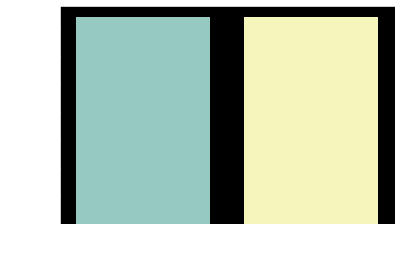

In [10]:
import seaborn as sns
sns.countplot(x=df["label"])

#Convert tokens into a numerical sequence:

In [12]:
X=df["text"]
#X=df["transformed_text"]

tokenizer = Tokenizer() #initializing the tokenizer
tokenizer.fit_on_texts(X)# fitting on the sms data
text_to_sequence = tokenizer.texts_to_sequences(X) # creating the numerical sequence

In [13]:
#tokenizer.index_word

In [14]:
len(tokenizer.index_word)

130902

#Normalization:
Since all the messages are of different lengths also the sequences are of different length, so we have to padding the sequences with 0 to get equal length. Otherwise the sequences would not be compatible for the model!

In [16]:
max_length_sequence = max([len(i) for i in text_to_sequence]) # finding the length of largest sequence
padded_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence, padding = "pre")
padded_sequence

array([[    0,     0,     0, ...,   144,    50,  1425],
       [    0,     0,     0, ..., 64908,   127, 50734],
       [    0,     0,     0, ...,   678,  1629,   143],
       ...,
       [    0,     0,     0, ...,  9087, 31381, 10197],
       [    0,     0,     0, ...,   127,   141,   108],
       [    0,     0,     0, ...,    51,   111,   523]], dtype=int32)

In [17]:
print("shape",len(padded_sequence), "rows x ",len(padded_sequence[0]),"cols")

shape 29624 rows x  21227 cols


#Create LSTM Model:

In [18]:
TOT_SIZE = len(tokenizer.word_index)+1


def create_model():
      lstm_model = Sequential()
      lstm_model.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_model.add(LSTM(100))
      lstm_model.add(Dropout(0.4))
      lstm_model.add(Dense(20, activation="relu"))

      lstm_model.add(Dropout(0.3))
      lstm_model.add(Dense(1, activation = "sigmoid"))
      return lstm_model

Metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
           ]

lstm_model = create_model()
lstm_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics=Metrics)

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21227, 32)         4188896   
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 20)                2020      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 4,244,137
Trainable params: 4,244,137
Non-

#Train Test Validation Split

In [19]:
from sklearn.model_selection import train_test_split
X=padded_sequence
y=df["label"]
X_train, X_val,  y_train, y_val  = train_test_split(X, y, test_size=0.7, random_state=42)
X_val,   X_test, y_val,   y_test = train_test_split(X_val, y_val, train_size=0.5)

#Train the model: 

In [20]:
from keras.callbacks import EarlyStopping

num_epochs = 100 #10!

es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='loss', mode='auto',
                       restore_best_weights=True)

history = lstm_model.fit(
               X_train ,
               y_train,
               epochs=num_epochs,
               validation_data=(X_val, y_val),
                callbacks=[es]
               #callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)]
          )

Epoch 1/100
278/278 [==============================] - 294s 1s/step - loss: 0.2800 - accuracy: 0.8835 - precision: 0.8667 - recall: 0.9039 - val_loss: 0.1102 - val_accuracy: 0.9601 - val_precision: 0.9808 - val_recall: 0.9391
Epoch 2/100
278/278 [==============================] - 276s 996ms/step - loss: 0.0546 - accuracy: 0.9840 - precision: 0.9872 - recall: 0.9805 - val_loss: 0.1012 - val_accuracy: 0.9645 - val_precision: 0.9667 - val_recall: 0.9627
Epoch 3/100
278/278 [==============================] - 279s 1s/step - loss: 0.0144 - accuracy: 0.9964 - precision: 0.9984 - recall: 0.9943 - val_loss: 0.1225 - val_accuracy: 0.9621 - val_precision: 0.9526 - val_recall: 0.9732
Epoch 4/100
278/278 [==============================] - 279s 1s/step - loss: 0.0164 - accuracy: 0.9952 - precision: 0.9943 - recall: 0.9959 - val_loss: 0.1378 - val_accuracy: 0.9634 - val_precision: 0.9587 - val_recall: 0.9692
Epoch 5/100
278/278 [==============================] - 279s 1s/step - loss: 0.0152 - accuracy

#SAVE MODEL AS PICKLE FILE:

In [23]:
y_pred = lstm_model.predict(X_test)
y_pred = y_pred.flatten() 
y_pred = np.where(y_pred > 0.5, 1, 0) #Why?

Classification Report:

In [24]:
from sklearn.utils import check_matplotlib_support
from sklearn.utils.validation import check_memory
from sklearn.metrics import confusion_matrix, classification_report

In [25]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5180
           1       0.96      0.97      0.96      5189

    accuracy                           0.96     10369
   macro avg       0.96      0.96      0.96     10369
weighted avg       0.96      0.96      0.96     10369



Confusion Matrix:

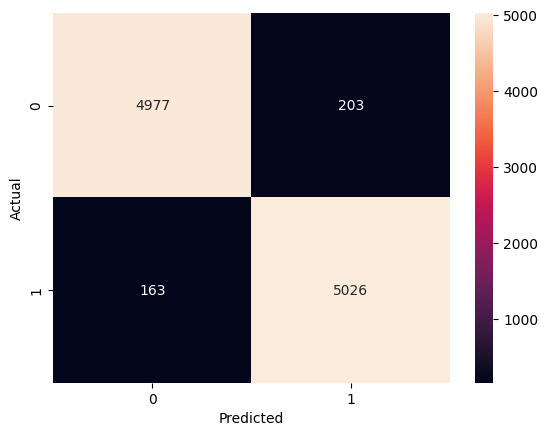

In [26]:
plt.style.use('default')
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
#plt.title(image_title_info+'Training and Validation loss')
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(image_folder+'cm.png')
plt.show()

Loss:

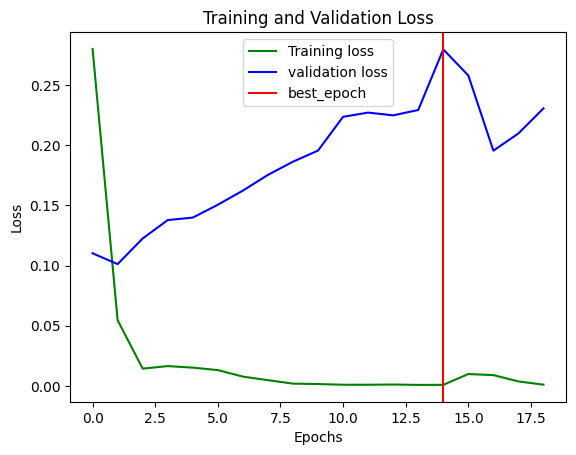

In [28]:
best_epoch = es.best_epoch + 1

#epochs = range(1, num_epochs+1)
plt.plot(history.history['loss'], 'g', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='validation loss')
plt.axvline(x=best_epoch, color='r', label='best_epoch')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig(image_folder+'loss.png')
plt.show()

Accuracy: 

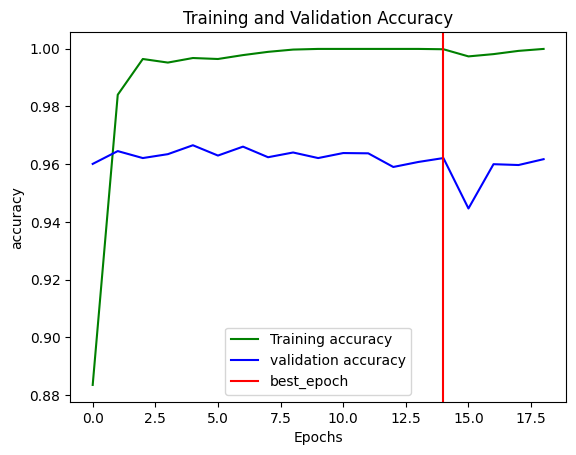

In [29]:
plt.plot( history.history['accuracy'], 'g', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='validation accuracy')
plt.axvline(x=best_epoch, color='r', label='best_epoch')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
#plt.savefig(image_folder+'accuracy.png')
plt.show()

Precission:

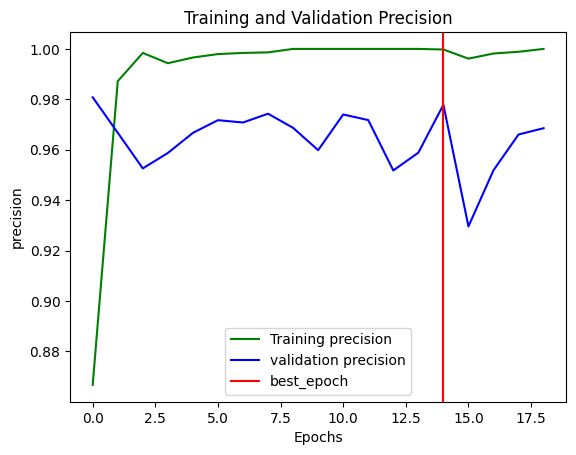

In [30]:
epochs = range(1, num_epochs+1)
plt.plot(history.history['precision'], 'g', label='Training precision')
plt.plot(history.history['val_precision'], 'b', label='validation precision')
plt.axvline(x=best_epoch, color='r', label='best_epoch')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()
#plt.savefig(image_folder+'precision.png')
plt.show()